In [4]:
!pip install pyspark==3.5.0 delta-spark==3.1.0 --quiet

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import types as T
from datetime import datetime

# Spark with Delta enabled
builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# ---------- Schema ----------
trip_schema = T.StructType([
    T.StructField("trip_id",      T.IntegerType()),
    T.StructField("rider_id",     T.StringType()),
    T.StructField("driver_id",    T.StringType()),
    T.StructField("city",         T.StringType()),
    T.StructField("distance_km",  T.DoubleType()),
    T.StructField("fare",         T.DoubleType()),
    T.StructField("tip",          T.DoubleType()),
    T.StructField("ts",           T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id",  T.StringType()),
    T.StructField("driver_name",T.StringType()),
    T.StructField("rating",     T.DoubleType()),
    T.StructField("vehicle",    T.StringType())
])

# ---------- Inline data (fixed with datetime) ----------
trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, datetime(2025,8,8,8,5,0)),
    (1002,"R002","D011","Hyderabad",  6.2, 150.0, 10.0, datetime(2025,8,8,8,15,0)),
    (1003,"R003","D012","Pune",       3.5,  90.0,  0.0, datetime(2025,8,8,8,20,0)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, datetime(2025,8,8,8,45,0)),
    (1005,"R004","D013","Chennai",   10.0, 260.0, 15.0, datetime(2025,8,8,9,5,0)),
    (1006,"R005","D012","Pune",       2.2,  70.0,  0.0, datetime(2025,8,8,9,10,0)),
]

drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz")
]

# Create DataFrames
trips_df   = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

# ---------- Save as Delta ----------
BASE = "/content/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded datasets:")
print("  Trips  ->", TRIPS_PATH)
print("  Drivers->", DRIVERS_PATH)


Seeded datasets:
  Trips  -> /content/delta/ride_hailing/trips
  Drivers-> /content/delta/ride_hailing/drivers


In [5]:
# 1-Managed vs Unmanaged Tables
# Managed table: trips_managed
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS trips_managed
    USING DELTA
    AS SELECT * FROM delta.`{TRIPS_PATH}`
""")

# Unmanaged table: drivers_ext
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS drivers_ext
    USING DELTA
    LOCATION '{DRIVERS_PATH}'
""")

print("Managed and Unmanaged tables created.")

# Verify locations
print("\n--- trips_managed detail ---")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)

print("\n--- drivers_ext detail ---")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)


Managed and Unmanaged tables created.

--- trips_managed detail ---
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |2c70921a-3d06-423f-8cf4-3987c64de186|spark

In [6]:
# 2- Read & Explore
from pyspark.sql import functions as F

# 1 & 2 - Read both tables and show schema + sample data
print("=== trips_managed ===")
trips_df = spark.table("trips_managed")
trips_df.printSchema()
trips_df.show(10, truncate=False)

print("=== drivers_ext ===")
drivers_df = spark.table("drivers_ext")
drivers_df.printSchema()
drivers_df.show(10, truncate=False)

# 3 - Derived column total_amount
trips_with_total = trips_df.withColumn("total_amount", F.col("fare") + F.col("tip"))

# 4 - Top 5 trips by total_amount
print("=== Top 5 trips by total_amount ===")
trips_with_total.orderBy(F.col("total_amount").desc()).show(5, truncate=False)


=== trips_managed ===
root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   

In [7]:
# 3-Update (Business Rule)
# Before update - only affected rows
print("=== Before update ===")
spark.sql("""
    SELECT *
    FROM trips_managed
    WHERE city = 'Bengaluru' AND distance_km > 15
""").show()

# Perform update
spark.sql("""
    UPDATE trips_managed
    SET tip = tip + 5
    WHERE city = 'Bengaluru' AND distance_km > 15
""")

# After update - only affected rows
print("=== After update ===")
spark.sql("""
    SELECT *
    FROM trips_managed
    WHERE city = 'Bengaluru' AND distance_km > 15
""").show()


=== Before update ===
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

=== After update ===
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [8]:
#4-Delete (Data Quality)
spark.sql("""
    DELETE FROM trips_managed
    WHERE fare <= 0 OR distance_km <= 0
""")

# Show remaining row count
remaining_count = spark.sql("SELECT COUNT(*) AS cnt FROM trips_managed").collect()[0]["cnt"]
print(f"Remaining trips after delete: {remaining_count}")

Remaining trips after delete: 6


In [9]:
#5-Merge (Upsert New Batch)
from datetime import datetime

# New batch data
merge_rows = [
    (1004,"R001","D010","Bengaluru", 18.9, 500.0, 30.0, datetime(2025,8,8,8,45,0)),  # updated fare & tip
    (1007,"R006","D011","Hyderabad",  7.0, 180.0, 12.0, datetime(2025,8,8,10,0,0))   # new trip
]

merge_schema = spark.table("trips_managed").schema
merge_df = spark.createDataFrame(merge_rows, schema=merge_schema)

# Save new batch to temp Delta path
temp_merge_path = "/content/delta/ride_hailing/new_batch"
merge_df.write.format("delta").mode("overwrite").save(temp_merge_path)

# Create temp table for merge
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS new_batch
    USING DELTA
    LOCATION '{temp_merge_path}'
""")

# Perform MERGE
spark.sql("""
    MERGE INTO trips_managed AS target
    USING new_batch AS source
    ON target.trip_id = source.trip_id
    WHEN MATCHED THEN UPDATE SET *
    WHEN NOT MATCHED THEN INSERT *
""")

print("Merge completed.")

# Showing rows
spark.sql("""
    SELECT * FROM trips_managed
    WHERE trip_id IN (1004, 1007)
""").show()


Merge completed.
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        7.0|180.0|12.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [10]:
#6- Gold View (Join & KPIs)
from pyspark.sql import functions as F

# Read the latest trips and drivers tables
trips_df = spark.table("trips_managed")
drivers_df = spark.table("drivers_ext")

# Add total_amount column
trips_with_total = trips_df.withColumn("total_amount", F.col("fare") + F.col("tip"))

# Join trips with drivers on driver_id
gold_df = trips_with_total.join(drivers_df, on="driver_id", how="inner") \
    .select(
        "trip_id", "city", "driver_name", "rating",
        "distance_km", "total_amount", "ts"
    )

# Create a temporary gold view
gold_df.createOrReplaceTempView("gold_view")

print("=== Gold View Sample ===")
gold_df.show(truncate=False)

# City-wise total revenue & average driver rating
city_kpi = spark.sql("""
    SELECT city,
           ROUND(SUM(total_amount), 2) AS total_revenue,
           ROUND(AVG(rating), 2) AS avg_driver_rating
    FROM gold_view
    GROUP BY city
    ORDER BY total_revenue DESC
""")
print("=== City-wise Revenue & Avg Driver Rating ===")
city_kpi.show()

# Driver-wise total trips
driver_kpi = spark.sql("""
    SELECT driver_name,
           COUNT(*) AS total_trips,
           ROUND(SUM(total_amount), 2) AS total_revenue
    FROM gold_view
    GROUP BY driver_name
    ORDER BY total_trips DESC
""")
print("=== Driver-wise Total Trips ===")
driver_kpi.show()

# Top 3 drivers by revenue
top3_drivers = driver_kpi.orderBy(F.col("total_revenue").desc()).limit(3)
print("=== Top 3 Drivers by Revenue ===")
top3_drivers.show()


=== Gold View Sample ===
+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|city     |driver_name|rating|distance_km|total_amount|ts                 |
+-------+---------+-----------+------+-----------+------------+-------------------+
|1004   |Bengaluru|Anil       |4.8   |18.9       |530.0       |2025-08-08 08:45:00|
|1005   |Chennai  |Meera      |4.9   |10.0       |275.0       |2025-08-08 09:05:00|
|1006   |Pune     |Rakesh     |4.4   |2.2        |70.0        |2025-08-08 09:10:00|
|1007   |Hyderabad|Sana       |4.6   |7.0        |192.0       |2025-08-08 10:00:00|
|1001   |Bengaluru|Anil       |4.8   |12.4       |340.0       |2025-08-08 08:05:00|
|1002   |Hyderabad|Sana       |4.6   |6.2        |160.0       |2025-08-08 08:15:00|
|1003   |Pune     |Rakesh     |4.4   |3.5        |90.0        |2025-08-08 08:20:00|
+-------+---------+-----------+------+-----------+------------+-------------------+

=== City-wise Revenue & Avg Driver Rating ===
+---

In [11]:
# 7- Time Travel & History
from pyspark.sql import functions as F

#Show DESCRIBE HISTORY for trips_managed
print("=== DESCRIBE HISTORY for trips_managed ===")
spark.sql("DESCRIBE HISTORY trips_managed").show(truncate=False)

#Read the table as of version 0
trips_v0 = spark.read.format("delta").option("versionAsOf", 0).table("trips_managed")

print("\n=== trips_managed at Version 0 ===")
trips_v0.show()

#Read the latest version of the table
trips_latest = spark.table("trips_managed")

print("\n=== trips_managed at Latest Version ===")
trips_latest.show()

# 4. Compare counts
print(f"\nRow count at Version 0: {trips_v0.count()}")
print(f"Row count at Latest Version: {trips_latest.count()}")


=== DESCRIBE HISTORY for trips_managed ===
+-------+-----------------------+------+--------+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---

In [12]:
#8-Partitioned Rewrite (Performance)
import time
import os

# Define new path for partitioned table
PARTITIONED_TRIPS_PATH = "/content/delta/ride_hailing/trips_partitioned"

# 1. Rewrite the trips table partitioned by city
spark.table("trips_managed") \
    .write.format("delta") \
    .mode("overwrite") \
    .partitionBy("city") \
    .save(PARTITIONED_TRIPS_PATH)

print(f"Partitioned trips table saved at: {PARTITIONED_TRIPS_PATH}")

# 2.Compare file layout
print("\n=== Files in partitioned trips table ===")
for root, dirs, files in os.walk(PARTITIONED_TRIPS_PATH):
    for file in files:
        print(os.path.join(root, file))

# 3. Read and filter city='Bengaluru' to observe read behavior/time
start_time = time.time()
bengaluru_df = spark.read.format("delta").load(PARTITIONED_TRIPS_PATH) \
    .filter(F.col("city") == "Bengaluru")
bengaluru_df.show()
end_time = time.time()

print(f"\nFilter query time (partitioned): {end_time - start_time:.4f} seconds")


Partitioned trips table saved at: /content/delta/ride_hailing/trips_partitioned

=== Files in partitioned trips table ===
/content/delta/ride_hailing/trips_partitioned/_delta_log/.00000000000000000000.json.crc
/content/delta/ride_hailing/trips_partitioned/_delta_log/00000000000000000000.json
/content/delta/ride_hailing/trips_partitioned/city=Chennai/part-00000-80cf80fd-065e-4fdb-86e3-693662615f60.c000.snappy.parquet
/content/delta/ride_hailing/trips_partitioned/city=Chennai/.part-00000-80cf80fd-065e-4fdb-86e3-693662615f60.c000.snappy.parquet.crc
/content/delta/ride_hailing/trips_partitioned/city=Hyderabad/part-00001-9deb4d77-3e1d-4364-8f45-abec952854af.c000.snappy.parquet
/content/delta/ride_hailing/trips_partitioned/city=Hyderabad/part-00000-31307d9f-e22f-470a-af04-8110f9368fd9.c000.snappy.parquet
/content/delta/ride_hailing/trips_partitioned/city=Hyderabad/.part-00000-31307d9f-e22f-470a-af04-8110f9368fd9.c000.snappy.parquet.crc
/content/delta/ride_hailing/trips_partitioned/city=Hyder

In [13]:
#9-Incremental Load Simulation
# Create small incremental batch (1008–1009, new city Mumbai)
incremental_rows = [
    (1008, "R006", "D010", "Mumbai", 15.0, 400.0, 30.0, datetime(2025, 8, 9, 10, 0, 0)),
    (1009, "R007", "D011", "Mumbai",  8.0, 200.0, 20.0, datetime(2025, 8, 9, 10, 30, 0))
]

incremental_df = spark.createDataFrame(incremental_rows, schema=trips_df.schema)

# Append to trips_managed table
incremental_df.write.format("delta").mode("append").saveAsTable("trips_managed")

print("Incremental data appended successfully.")

# Re-run city-wise revenue (fare + tip) only
city_revenue = spark.table("trips_managed") \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .groupBy("city") \
    .agg(F.round(F.sum("total_amount"), 2).alias("total_revenue")) \
    .orderBy(F.col("total_revenue").desc())

print("=== Updated City-wise Revenue ===")
city_revenue.show()


Incremental data appended successfully.
=== Updated City-wise Revenue ===
+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bengaluru|        870.0|
|   Mumbai|        650.0|
|Hyderabad|        352.0|
|  Chennai|        275.0|
|     Pune|        160.0|
+---------+-------------+



In [14]:
#10-Simple Streaming (File Stream → Console)
from pyspark.sql import functions as F
from datetime import datetime

# 1. Start a structured stream that reads Delta from TRIPS_PATH in readStream mode
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)

query = stream_df.writeStream \
    .format("console") \
    .outputMode("append") \
    .trigger(processingTime="5 seconds") \
    .start()

print("Streaming started... appending a new row in a moment.")

# 2. Append another tiny batch while the stream runs (one more Mumbai trip)
new_trip = [
    (1010, "R008", "D012", "Mumbai", 12.0, 300.0, 25.0, datetime(2025, 8, 9, 11, 0, 0))
]

new_trip_df = spark.createDataFrame(new_trip, schema=trips_df.schema)
new_trip_df.write.format("delta").mode("append").save(TRIPS_PATH)

print("New Mumbai trip appended.")

Streaming started... appending a new row in a moment.
New Mumbai trip appended.


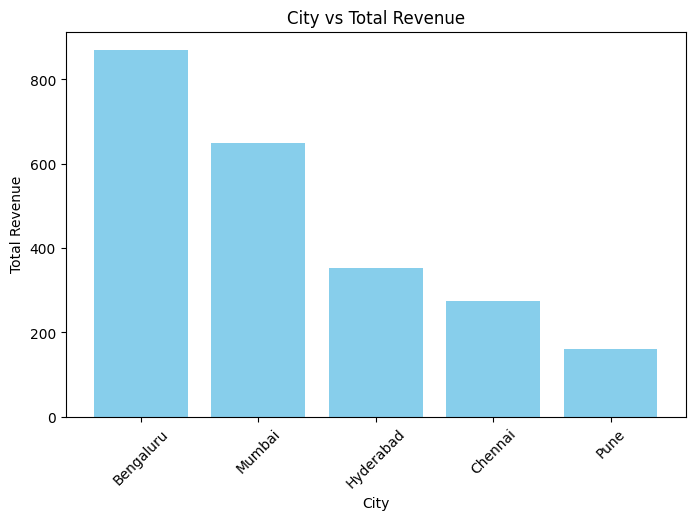

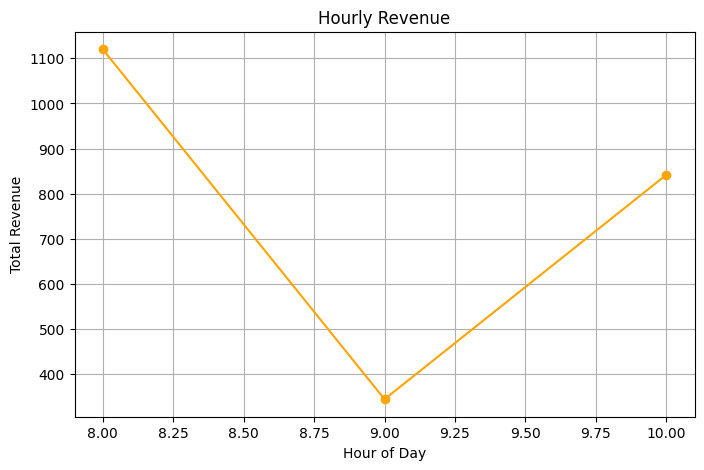

In [15]:
#11-Visualization
import matplotlib.pyplot as plt

# 1. City-wise total revenue (from Gold View)
city_revenue_df = spark.sql("""
    SELECT city,
           ROUND(SUM(total_amount), 2) AS total_revenue
    FROM gold_view
    GROUP BY city
    ORDER BY total_revenue DESC
""")

# Convert to Pandas for plotting
city_revenue_pd = city_revenue_df.toPandas()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(city_revenue_pd['city'], city_revenue_pd['total_revenue'], color='skyblue')
plt.title("City vs Total Revenue")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

# 2. Hourly revenue
hourly_revenue_df = spark.sql("""
    SELECT HOUR(ts) AS hour,
           ROUND(SUM(total_amount), 2) AS total_revenue
    FROM gold_view
    GROUP BY HOUR(ts)
    ORDER BY hour
""")

hourly_revenue_pd = hourly_revenue_df.toPandas()

# Plot line chart
plt.figure(figsize=(8, 5))
plt.plot(hourly_revenue_pd['hour'], hourly_revenue_pd['total_revenue'], marker='o', color='orange')
plt.title("Hourly Revenue")
plt.xlabel("Hour of Day")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()


In [16]:
#12-Managed vs Unmanaged Cleanup
import os

# 1. Drop the managed table
spark.sql("DROP TABLE IF EXISTS trips_managed")
print("Dropped managed table: trips_managed")

# 2. Drop the unmanaged table
spark.sql("DROP TABLE IF EXISTS drivers_ext")
print("Dropped unmanaged table: drivers_ext")

# 3. Verify managed table data is removed
print("\n=== Checking managed table data path ===")
try:
    spark.table("trips_managed").show()
except Exception as e:
    print("Managed table data removed:", e)

# 4. Verify unmanaged table data still exists
print("\n=== Checking unmanaged table path ===")
if os.path.exists(DRIVERS_PATH):
    print("Unmanaged table data still exists at:", DRIVERS_PATH)
    print("Files:", os.listdir(DRIVERS_PATH))
else:
    print("Unmanaged table path not found.")


Dropped managed table: trips_managed
Dropped unmanaged table: drivers_ext

=== Checking managed table data path ===
Managed table data removed: [TABLE_OR_VIEW_NOT_FOUND] The table or view `trips_managed` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.;
'UnresolvedRelation [trips_managed], [], false


=== Checking unmanaged table path ===
Unmanaged table data still exists at: /content/delta/ride_hailing/drivers
Files: ['_delta_log', 'part-00001-00a0bb15-844c-4629-984e-9826a7874dbb-c000.snappy.parquet', 'part-00001-d1d519ab-7367-4a73-b55b-093a22c39e73-c000.snappy.parquet', 'part-00000-74e833d7-367f-4de8-98ec-2f768143bd39-c000.snappy.parquet', 'part-00000-5129b6bb-174b-4f4f-a426-13ad9801e155-c000.snappy.parquet', '.part-00001-d1d519ab-7367-4a

In [17]:
#13- Constraint/Quality Check (Optional)
from datetime import datetime

# Bad data example: tip < 0
bad_data = [
    (2001, "R999", "D010", "Bengaluru", 10.0, 250.0, -5.0, datetime(2025, 8, 10, 10, 0, 0))
]
bad_df = spark.createDataFrame(bad_data, schema=trip_schema)

print("=== Attempt to write bad data (tip < 0) ===")

# Simulate constraint: reject if tip < 0
if bad_df.filter(F.col("tip") < 0).count() > 0:
    print("Bad data rejected: tip < 0 not allowed.")
else:
    bad_df.write.format("delta").mode("append").save(TRIPS_PATH)
    print("Data written successfully.")


=== Attempt to write bad data (tip < 0) ===
Bad data rejected: tip < 0 not allowed.
